In [3]:
import pandas as pd
import numpy as np


In [4]:


def add_basic_features(df):
    """
    Add basic engineered features to the car dataset
    """
    # Create a copy to avoid modifying original data
    df_new = df.copy()
    
    print("=== ADDING BASIC FEATURES ===")
    
    # 1. Car Age (assuming current year is 2024)
    if 'year' in df_new.columns:
        current_year = 2024
        df_new['car_age'] = current_year - df_new['year']
        print(f"✓ Added car_age feature")
        print(f"  Age range: {df_new['car_age'].min()} to {df_new['car_age'].max()} years")
    else:
        print("'year' column not found - cannot create car_age")
    
    # 2. Extract Brand Name from car name
    if 'name' in df_new.columns:
        # Extract first word as brand name
        df_new['brand_name'] = df_new['name'].str.split().str[0]
        print(f"✓ Added brand_name feature")
        print(f"  Unique brands: {df_new['brand_name'].nunique()}")
        print(f"  Top brands: {df_new['brand_name'].value_counts().head(3).to_dict()}")
    else:
        print("'name' column not found - cannot extract brand_name")
    
    # 3. Average KM per Year
    if 'km_driven' in df_new.columns and 'car_age' in df_new.columns:
        # Avoid division by zero for brand new cars
        df_new['avg_km_per_year'] = df_new['km_driven'] / df_new['car_age'].replace(0, 1)
        print(f"✓ Added avg_km_per_year feature")
        print(f"  Range: {df_new['avg_km_per_year'].min():.0f} to {df_new['avg_km_per_year'].max():.0f} km/year")
    else:
        print("Required columns not found - cannot create avg_km_per_year")
    
    # 4. Brand Popularity (based on frequency)
    if 'brand_name' in df_new.columns:
        brand_counts = df_new['brand_name'].value_counts()
        df_new['brand_popularity'] = df_new['brand_name'].map(brand_counts)
        print(f"✓ Added brand_popularity feature")
        print(f"  Most popular brand: {brand_counts.index[0]} ({brand_counts.iloc[0]} cars)")
        print(f"  Least popular brands: {len(brand_counts[brand_counts == 1])} brands with only 1 car")
    else:
        print("'brand_name' column not found - cannot create brand_popularity")
    
    # 5. Price per KM (price divided by km_driven)
    if 'selling_price' in df_new.columns and 'km_driven' in df_new.columns:
        # Avoid division by zero
        df_new['price_per_km'] = df_new['selling_price'] / df_new['km_driven'].replace(0, np.nan)
        print(f"✓ Added price_per_km feature")
        print(f"  Range: {df_new['price_per_km'].min():.2f} to {df_new['price_per_km'].max():.2f} per km")
    else:
        print("Required columns not found - cannot create price_per_km")
    
    print(f"\nOriginal columns: {df.shape[1]}")
    print(f"New columns: {df_new.shape[1]}")
    print(f"Features added: {df_new.shape[1] - df.shape[1]}")
    
    return df_new





In [5]:
# Load your processed data
df = pd.read_csv('../results/outputs/outliers_removal.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Add the new features
df_with_features = add_basic_features(df)

# Display sample of new features
print("\n=== SAMPLE OF NEW FEATURES ===")
new_columns = ['car_age', 'brand_name', 'avg_km_per_year', 'brand_popularity', 'price_per_km']
available_new_cols = [col for col in new_columns if col in df_with_features.columns]

if available_new_cols:
    print(df_with_features[available_new_cols].head())
    
    # Show some statistics
    print("\n=== FEATURE STATISTICS ===")
    for col in available_new_cols:
        if df_with_features[col].dtype in ['int64', 'float64'] or np.issubdtype(df_with_features[col].dtype, np.number):
            print(f"{col}:")
            print(f"  Mean: {df_with_features[col].mean():.2f}")
            print(f"  Std: {df_with_features[col].std():.2f}")
        else:
            print(f"{col}: {df_with_features[col].value_counts().head(3).to_dict()}")

Dataset shape: (3063, 13)
Columns: ['Unnamed: 0', 'name', 'year', 'selling_price', 'km_driven', 'transmission', 'owner', 'fuel_Diesel', 'fuel_Electric', 'fuel_LPG', 'fuel_Petrol', 'seller_type_Individual', 'seller_type_Trustmark Dealer']
=== ADDING BASIC FEATURES ===
✓ Added car_age feature
  Age range: 4.0 to 23.0 years
✓ Added brand_name feature
  Unique brands: 20
  Top brands: {'Maruti': 989, 'Hyundai': 573, 'Tata': 286}
✓ Added avg_km_per_year feature
  Range: 0 to 30000 km/year
✓ Added brand_popularity feature
  Most popular brand: Maruti (989 cars)
  Least popular brands: 2 brands with only 1 car
✓ Added price_per_km feature
  Range: 0.35 to 250000.00 per km

Original columns: 13
New columns: 18
Features added: 5

=== SAMPLE OF NEW FEATURES ===
   car_age brand_name  avg_km_per_year  brand_popularity  price_per_km
0     17.0     Maruti      4117.647059               989      0.857143
1     17.0     Maruti      2941.176471               989     10.087117
2     12.0    Hyundai    

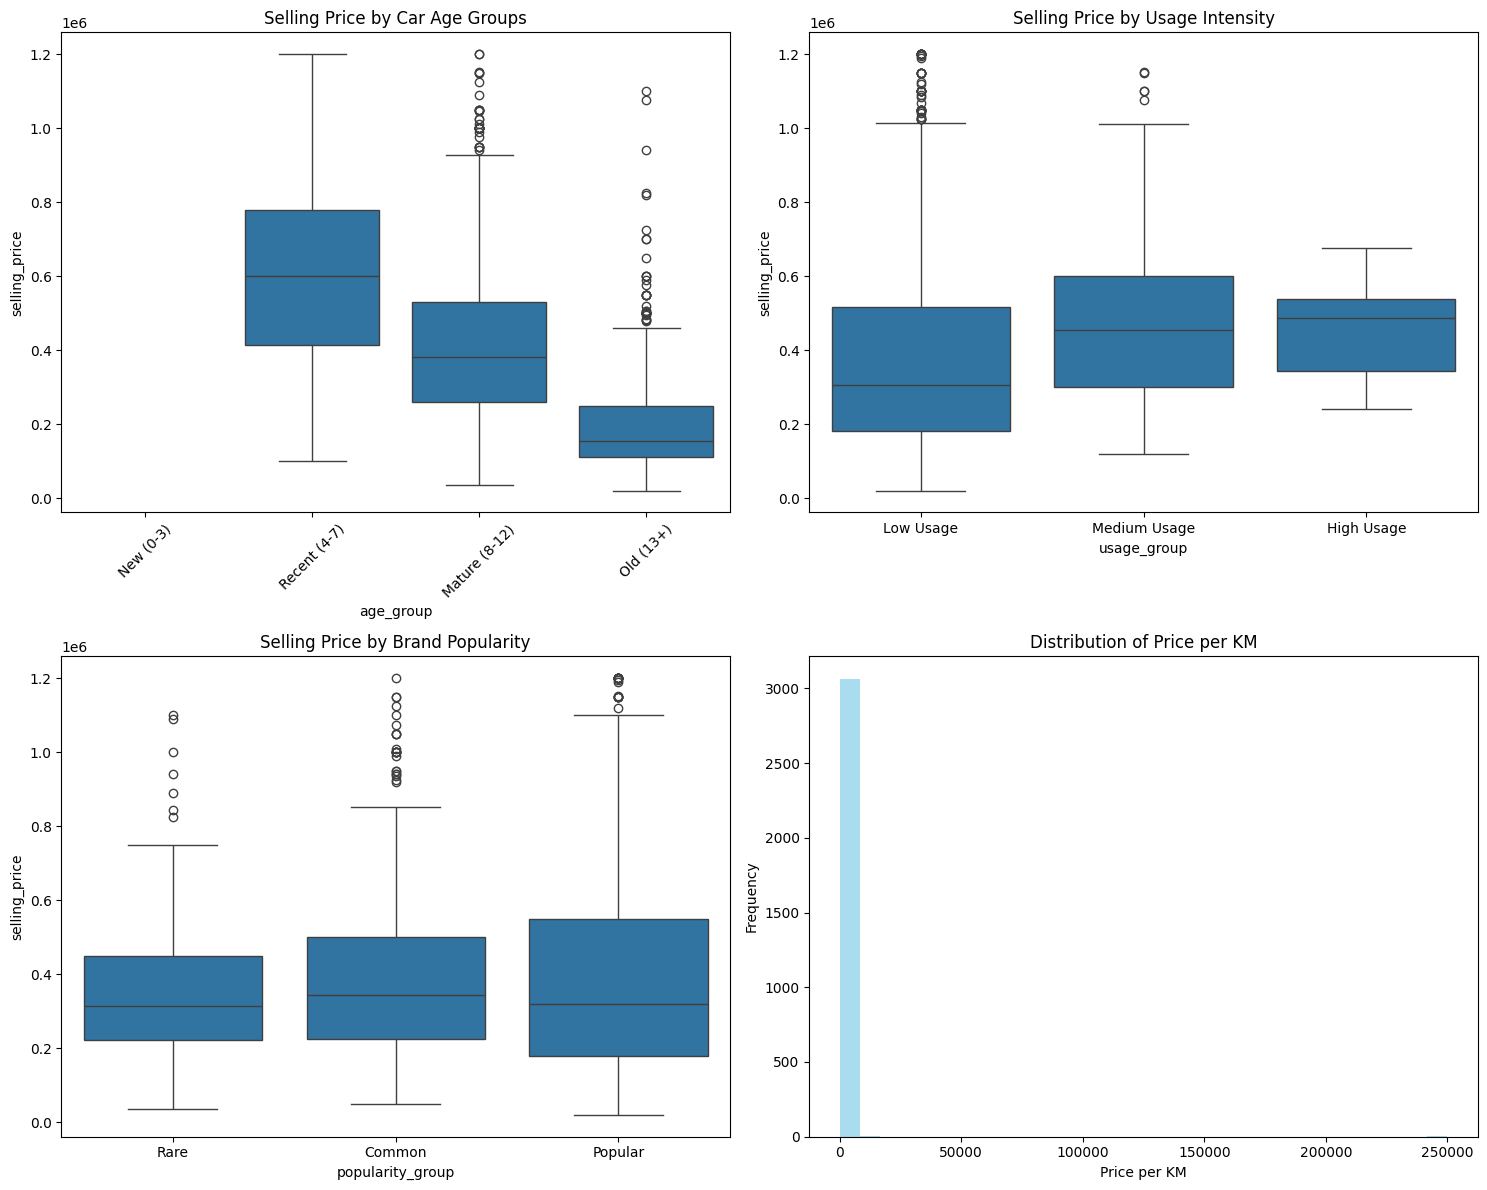

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
def create_feature_impact_boxplots():
    """
    Create boxplots showing how new features relate to selling price
    """
    # Create figure with subplots for new features
    new_features = ['car_age', 'avg_km_per_year', 'brand_popularity', 'price_per_km']
    available_features = [f for f in new_features if f in df_with_features.columns]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, feature in enumerate(available_features):
        if i < 4:  # We have 4 subplot positions
            ax = axes[i]
            
            if feature == 'car_age':
                # Create age groups for better visualization
                df_with_features['age_group'] = pd.cut(df_with_features['car_age'], 
                                                     bins=[0, 3, 7, 12, 20], 
                                                     labels=['New (0-3)', 'Recent (4-7)', 'Mature (8-12)', 'Old (13+)'])
                sns.boxplot(data=df_with_features, x='age_group', y='selling_price', ax=ax)
                ax.set_title('Selling Price by Car Age Groups')
                ax.tick_params(axis='x', rotation=45)
                
            elif feature == 'avg_km_per_year':
                # Create usage intensity groups
                df_with_features['usage_group'] = pd.cut(df_with_features['avg_km_per_year'], 
                                                       bins=[0, 10000, 20000, float('inf')], 
                                                       labels=['Low Usage', 'Medium Usage', 'High Usage'])
                sns.boxplot(data=df_with_features, x='usage_group', y='selling_price', ax=ax)
                ax.set_title('Selling Price by Usage Intensity')
                
            elif feature == 'brand_popularity':
                # Create popularity groups
                df_with_features['popularity_group'] = pd.cut(df_with_features['brand_popularity'], 
                                                            bins=[0, 50, 150, float('inf')], 
                                                            labels=['Rare', 'Common', 'Popular'])
                sns.boxplot(data=df_with_features, x='popularity_group', y='selling_price', ax=ax)
                ax.set_title('Selling Price by Brand Popularity')
                
            elif feature == 'price_per_km':
                # Show distribution of price per km
                ax.hist(df_with_features['price_per_km'].dropna(), bins=30, alpha=0.7, color='skyblue')
                ax.set_title('Distribution of Price per KM')
                ax.set_xlabel('Price per KM')
                ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('../results/eda_visualizations/feature_engineering_impact.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function
create_feature_impact_boxplots()

In [7]:
# Save the enhanced dataset
df_with_features.to_csv('../results/outputs/data_with_basic_features.csv', index=False)

In [8]:
# One-hot encode the new features and save the encoded dataset
from sklearn.preprocessing import OneHotEncoder

# Select columns to encode (categorical features)
categorical_cols = ['brand_name']  # Add more if needed

# Only encode columns that exist in the DataFrame
categorical_cols = [col for col in categorical_cols if col in df_with_features.columns]

if categorical_cols:
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded = encoder.fit_transform(df_with_features[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
    
    # Concatenate with the rest of the DataFrame (drop original categorical columns)
    df_encoded = pd.concat([df_with_features.drop(columns=categorical_cols).reset_index(drop=True), encoded_df], axis=1)
    
    print(f"One-hot encoded columns: {encoded_df.columns.tolist()}")
    print(f"Encoded DataFrame shape: {df_encoded.shape}")
    
    # Save the encoded dataset
    df_encoded.to_csv('../results/outputs/featured_encoded_data.csv', index=False)
    print("Encoded dataset saved to '../results/outputs/featured_encoded_data.csv'")
else:
    print("No categorical columns found for encoding.")

One-hot encoded columns: ['brand_name_Chevrolet', 'brand_name_Daewoo', 'brand_name_Datsun', 'brand_name_Fiat', 'brand_name_Force', 'brand_name_Ford', 'brand_name_Honda', 'brand_name_Hyundai', 'brand_name_Mahindra', 'brand_name_Maruti', 'brand_name_Mercedes-Benz', 'brand_name_Mitsubishi', 'brand_name_Nissan', 'brand_name_OpelCorsa', 'brand_name_Renault', 'brand_name_Skoda', 'brand_name_Tata', 'brand_name_Toyota', 'brand_name_Volkswagen']
Encoded DataFrame shape: (3063, 39)
Encoded dataset saved to '../results/outputs/featured_encoded_data.csv'


In [9]:
# --- Save the fitted encoder for future use ---
import joblib

# Fit the encoder on the training data (if not already done)
categorical_cols = ['brand_name']
categorical_cols = [col for col in categorical_cols if col in df_with_features.columns]

if categorical_cols:
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoder.fit(df_with_features[categorical_cols])
    # Save the encoder
    joblib.dump(encoder, '../results/outputs/brand_name_encoder.joblib')
    print("Encoder saved to '../results/outputs/brand_name_encoder.joblib'")
else:
    print("No categorical columns found for encoding.")

# --- Example: Load and use the encoder for a new dataset ---
# df_new_with_features = ... # Load or create your new dataset with the same features
# encoder = joblib.load('../results/outputs/brand_name_encoder.joblib')
# encoded = encoder.transform(df_new_with_features[categorical_cols])
# encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
# df_new_encoded = pd.concat([df_new_with_features.drop(columns=categorical_cols).reset_index(drop=True), encoded_df], axis=1)
# df_new_encoded.to_csv('../results/outputs/new_encoded_data.csv', index=False)
# print("New dataset encoded and saved.")

Encoder saved to '../results/outputs/brand_name_encoder.joblib'
